In [1]:
import sys
sys.path.append("../")
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageNet, CIFAR10

from PyTorch_CIFAR10.cifar10_models.mobilenetv2 import mobilenet_v2
from PyTorch_CIFAR10.UTILS_TORCH import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Currently using: '{device}'")

Currently using: 'cuda'


# ImageNet

### Functions

In [3]:
# Assuming your data is in CIFAR-like format (data is flattened)
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict


def parse_class_map(file_path):
    """
    Parses the class map file to get a dictionary mapping ImageNet class ID to the class index.
    """
    class_map = {}
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split(" ", 2)  # Split by first two spaces
            class_id = parts[0]  # ImageNet ID (e.g., n01440764)
            class_index = int(parts[1])  # Corresponding integer index (e.g., 0)
            class_map[class_id] = class_index
    return class_map

### Class Maps

In [4]:
# Load the class map from map_clsloc.txt
class_map = parse_class_map("../PyTorch_CIFAR10/data/map_clsloc.txt")

In [5]:
cifar10_imagenet_classes = {
    # plane
    0: [
        "n02690373",  # airliner
        "n04552348",  # warplane
        "n02692877"   # airship
    ],
    # car
    1: [
        "n04285008",  # sports_car
        "n03895866",  # passenger_car
        # "n03444034",  # go_kart
        # "n03445924",  # golf_cart
        # "n03977966",  # police_van
        # "n03770679",  # minivan
        # "n03796401",  # moving_van
        "n03930630",  # pickup
        "n03777568",  # model_T
        # "n04465501",  # tractor
        "n02930766",  # cab
        "n03100240",  # convertible
        # "n03670208",  # limousine
        "n03594945",  # jeep
    ],
    # bird
    2: [
        "n01514668",  # cock
        "n01514859",  # hen
        "n01833805",  # hummingbird
        "n01530575",  # brambling
        "n01531178",  # goldfinch
        "n01532829",  # house_finch
        "n01534433",  # junco
        "n01537544",  # indigo_bunting
        "n01558993",  # robin
        "n01560419",  # bulbul
        "n01580077",  # jay
        "n01582220",  # magpie
        "n01592084",  # chickadee
        "n01601694",  # water_ouzel
        "n01608432",  # kite
        "n01614925",  # bald_eagle
        "n01616318",  # vulture
        "n01622779",  # great_grey_owl
        "n01795545",  # black_grouse
        "n01796340",  # ptarmigan
        "n01797886",  # ruffed_grouse
        "n01798484",  # prairie_chicken
        "n01806143",  # peacock
        "n01806567",  # quail
        "n01807496",  # partridge
        "n01817953",  # African_grey
        "n01818515",  # macaw
        "n01819313",  # sulphur-crested_cockatoo
        "n01820546",  # lorikeet
        "n01824575",  # coucal
        "n01828970",  # bee_eater
        "n01829413",  # hornbill
        "n01843065",  # jacamar
        "n01843383",  # toucan
        "n01847000",  # drake
        "n01855032",  # red-breasted_merganser
        "n01855672",  # goose
        "n01860187",  # black_swan
        "n02002556",  # white_stork
        "n02002724",  # black_stork
        "n02006656",  # spoonbill
        "n02007558",  # flamingo
        "n02009912",  # American_egret
        "n02009229",  # little_blue_heron
        "n02011460",  # bittern
        "n02012849",  # crane
        "n02013706",  # limpkin
        "n02018207",  # American_coot
        "n02018795",  # bustard
        "n02025239",  # ruddy_turnstone
        "n02027492",  # red-backed_sandpiper
        "n02028035",  # redshank
        "n02033041",  # dowitcher
        "n02037110",  # oystercatcher
        "n02017213",  # European_gallinule
        "n02051845",  # pelican
        "n02056570",  # king_penguin
        "n02058221",  # albatross
    ],
    # cat
    3: [
        "n02124075",  # Egyptian_cat
        "n02123394",  # persian_cat
        "n02123159",  # tiger_cat
        "n02123045",  # tabby_cat
        "n02123597",  # Siamese_cat
    ],
    # deer
    4: [],  # No direct deer class in ImageNet

    # dog
    5: [
        "n02110185",  # Siberian_husky
        "n02110063",  # malamute
        "n02091244",  # Ibizan_hound
        "n02091134",  # whippet
        "n02088364",  # beagle
        "n02099712",  # Labrador_retriever
        "n02099429",  # curly-coated_retriever
        "n02097130",  # giant_schnauzer
        "n02097209",  # standard_schnauzer
        "n02098413",  # Lhasa
        "n02098286",  # West_Highland_white_terrier
        "n02096177",  # cairn
        "n02106662",  # German_shepherd
        "n02099601",  # golden_retriever
        "n02095570",  # Lakeland_terrier
    ],
    
    # frog
    6: [
        "n01644900",  # tailed_frog
        "n01641577",  # bullfrog
        "n01644373",  # tree_frog
        # "n01667114",  # mud_turtle
    ],

    # horse
    7: [],  # No direct horse class

    # ship
    8: [
        "n04612504",  # yacht
        "n02687172",  # aircraft_carrier
        "n04147183",  # schooner
        "n03662601",  # lifeboat
        # "n04347754",  # submarine
        "n02951358",  # canoe
    ],

    # truck
    9: [
        "n04467665",  # trailer_truck
        "n03417042",  # garbage_truck
    ]
}


## Rest of the code

In [6]:
# Handle missing class IDs
missing_class_ids = {}

# Step 2: Map desired class IDs to indices and store them as a dictionary
desired_class_indices = {}

# Iterate over CIFAR-10 categories
for cifar10_class, class_ids in cifar10_imagenet_classes.items():
    class_indices = []
    for class_id in class_ids:
        if class_id in class_map:
            class_indices.append(class_map[class_id])
        else:
            # Log missing class IDs for this CIFAR-10 class
            if cifar10_class not in missing_class_ids:
                missing_class_ids[cifar10_class] = []
            missing_class_ids[cifar10_class].append(class_id)
    
    # Assign the mapped indices to the CIFAR-10 class in the new dictionary
    desired_class_indices[cifar10_class] = class_indices

# Check for missing class IDs and log them
if missing_class_ids:
    print(
        f"Warning: The following class IDs were not found in the class map:\n{missing_class_ids}"
    )
else:
    print("All desired class IDs found in the class map.")

All desired class IDs found in the class map.


In [7]:
desired_class_indices

{0: [230, 231, 232],
 1: [274, 257, 281, 272, 267, 268, 269],
 2: [383,
  384,
  415,
  386,
  387,
  388,
  389,
  390,
  391,
  392,
  393,
  394,
  395,
  396,
  397,
  398,
  399,
  400,
  401,
  402,
  403,
  404,
  405,
  406,
  407,
  408,
  409,
  410,
  411,
  412,
  413,
  414,
  416,
  417,
  418,
  419,
  420,
  421,
  422,
  423,
  424,
  425,
  426,
  427,
  428,
  429,
  430,
  431,
  432,
  433,
  434,
  435,
  436,
  437,
  438,
  439,
  440,
  441],
 3: [8, 10, 55, 174, 95],
 4: [],
 5: [3, 15, 204, 20, 132, 176, 144, 36, 156, 56, 71, 91, 211, 125, 152],
 6: [501, 499, 500],
 7: [],
 8: [240, 246, 221, 238, 239],
 9: [283, 280]}

### Load ImageNet

In [8]:
# Load the unpickled data
imagenet = unpickle("../PyTorch_CIFAR10/data/val_data")

# Extract labels and data
labels = imagenet["labels"]
data = imagenet["data"]  # Assuming the data is in a flattened format

In [9]:
len(labels)

50000

51


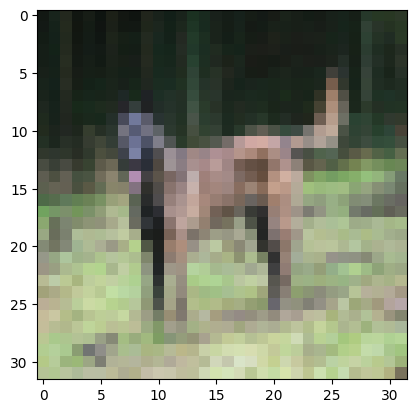

In [10]:
plt.imshow(data[5].reshape(3,32,32).transpose(1,2,0));
print(labels[5])

### Filter based on desired labels

In [11]:
# Filter data based on desired classes
filtered_indices = []

# Iterate through each label in the dataset
for i, label in enumerate(labels):
    # Check if the label matches any class in desired_class_indices
    for cifar10_class, class_indices in desired_class_indices.items():
        if label in class_indices:
            filtered_indices.append(i)
            break  # Exit the inner loop as we've found a match for this label

# Extract the filtered data and labels
filtered_data = data[filtered_indices]
filtered_labels = []

# Map the filtered ImageNet class indices to their corresponding CIFAR-10 labels
for i in filtered_indices:
    for cifar10_class, class_indices in desired_class_indices.items():
        if labels[i] in class_indices:
            filtered_labels.append(cifar10_class)
            break  # Exit the loop once the match is found


In [12]:
len(filtered_labels), np.max(filtered_labels), np.min(filtered_labels)

(4900, 9, 0)

In [13]:
num_samples = {i for i in filtered_labels}

In [14]:
num_samples = {}
for i in filtered_labels:
    num_samples[i] = 0

for i in filtered_labels:
    num_samples[i] +=1

In [15]:
num_samples

{2: 2900, 3: 250, 0: 150, 5: 750, 6: 150, 1: 350, 9: 100, 8: 250}

### Preprocess the Images

In [16]:
# Here, 32x32x3 images are stored as rows in the data matrix
num_images = len(filtered_data)
reshaped_data = filtered_data.reshape(
    num_images, 3, 32, 32
)  # Change the shape to [num_images, 3, 32, 32]

In [17]:
reshaped_data[0].shape

(3, 32, 32)

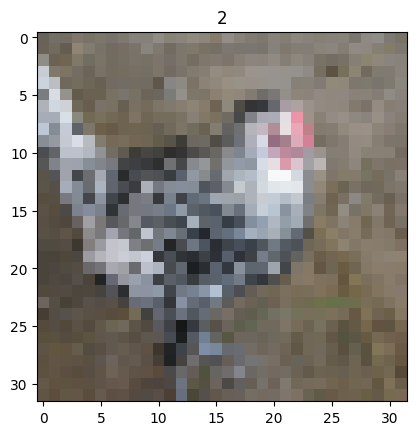

In [18]:
plt.imshow(reshaped_data[0].transpose(1,2,0))
plt.title(filtered_labels[0])
plt.show()

In [19]:
# Define the transforms for the dataset
teacher_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616]
        ),
    ]
)

In [20]:
reshaped_data = reshaped_data.transpose(0, 2, 3, 1)
reshaped_data.shape

(4900, 32, 32, 3)

In [21]:
# Convert to PyTorch tensors
# images_tensor = torch.tensor(reshaped_data, dtype=torch.float32)
images_tensor = torch.stack([teacher_transform(img) for img in reshaped_data])
labels_tensor = torch.tensor(filtered_labels, dtype=torch.long)

In [22]:
images_tensor[0].shape, labels_tensor[0].shape

(torch.Size([3, 32, 32]), torch.Size([]))

In [23]:
images_tensor.max()

tensor(2.1265)

### ImageNet Subset DataLoader

In [24]:
# Optionally, create a dataset and dataloader
dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

### Load Teacher CIFAR10

In [25]:
# load student data
teacher_test_data = CIFAR10(
    root="../PyTorch_CIFAR10/data",
    train=False,
    transform=teacher_transform,
)

In [26]:
test_loader = DataLoader(
    teacher_test_data,
    batch_size=64,
    shuffle=False,
    num_workers=16,
    pin_memory=False,
    persistent_workers=True,
)

### Evaluate the teacher model

In [27]:
model = mobilenet_v2(pretrained=True)
model.to(device);

In [28]:
test_model(model=model, loader=test_loader, device=device)

Accuracy of the model on the Training images: 93.92


In [29]:
test_model(model=model, loader=dataloader, device=device)

Accuracy of the model on the Training images: 68.81632653061224


In [30]:
metrics = evaluate_model_performance(model=model, dataloader=dataloader, device=device, num_classes=10)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# Print F1-Score report
print("\nF1-Score Report:")
for class_idx, report in metrics["f1_report"].items():
    if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
        print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
print("\nConfusion Matrix:")
print(metrics["confusion_matrix"])

Class-wise Accuracy:
Class 0: 84.00%
Class 1: 60.29%
Class 2: 73.31%
Class 3: 81.20%
Class 4: 0.00%
Class 5: 46.27%
Class 6: 66.00%
Class 7: 0.00%
Class 8: 77.60%
Class 9: 66.00%

F1-Score Report:
Class 0: {'precision': 0.3442622950819672, 'recall': 0.84, 'f1-score': 0.4883720930232558, 'support': 150.0}
Class 1: {'precision': 0.9213973799126638, 'recall': 0.6028571428571429, 'f1-score': 0.7288428324697754, 'support': 350.0}
Class 2: {'precision': 0.9453090262338817, 'recall': 0.733103448275862, 'f1-score': 0.8257914158088949, 'support': 2900.0}
Class 3: {'precision': 0.3704379562043796, 'recall': 0.812, 'f1-score': 0.5087719298245614, 'support': 250.0}
Class 4: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0}
Class 5: {'precision': 0.8943298969072165, 'recall': 0.46266666666666667, 'f1-score': 0.6098418277680141, 'support': 750.0}
Class 6: {'precision': 0.309375, 'recall': 0.66, 'f1-score': 0.42127659574468085, 'support': 150.0}
Class 7: {'precision': 0.0, 'recall': 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


# Compute IGs on ImageNet

In [62]:
# Optionally, create a dataset and dataloader
dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False)

In [63]:
import captum
from captum.attr import IntegratedGradients

In [64]:
ig_captum = IntegratedGradients(model)

captum_igs = []  # Store Captum's integrated gradients

# Wrap the DataLoader with tqdm for a progress bar
for inputs, targets in tqdm(dataloader, desc="Computing IGs", leave=True):
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Compute attributions using Captum
    attributions = ig_captum.attribute(
        inputs, target=targets, baselines=inputs * 0, return_convergence_delta=False
    )
    # Sum attributions over the channel dimension and take absolute value
    attributions_summed = torch.sum(torch.abs(attributions), dim=1).cpu().numpy()

    captum_igs.append(attributions_summed)

captum_igs = np.concatenate(captum_igs, axis=0)
np.save('imagenet_igs.npy', captum_igs)
print(f"Shape of IGs array: {captum_igs.shape}")

Computing IGs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 613/613 [01:36<00:00,  6.32it/s]

Shape of IGs array: (4900, 32, 32)


In [65]:
def process_ig(ig):
    return np.repeat(np.expand_dims(ig, axis=3), 3, axis=-1)

In [66]:
igs_expanded = process_ig(captum_igs)
igs_expanded.shape

(4900, 32, 32, 3)

In [67]:
igs_norm, _, _ = norm(igs_expanded)

In [68]:
igs_norm.max()

1.0

In [69]:
# Convert to PyTorch tensors
norm_data, _, _ = norm(reshaped_data)
imagenet_tensor = torch.tensor(norm_data, dtype=torch.float32)

# Optionally, create a dataset and dataloader
imagenet_ig = torch.utils.data.TensorDataset(imagenet_tensor, labels_tensor)

In [70]:
img, label = imagenet_ig[4]
img.max()

tensor(0.9882)

In [71]:
image = img.numpy()

In [72]:
overlay_image = 0.5 * igs_norm[4] + 0.5 * image

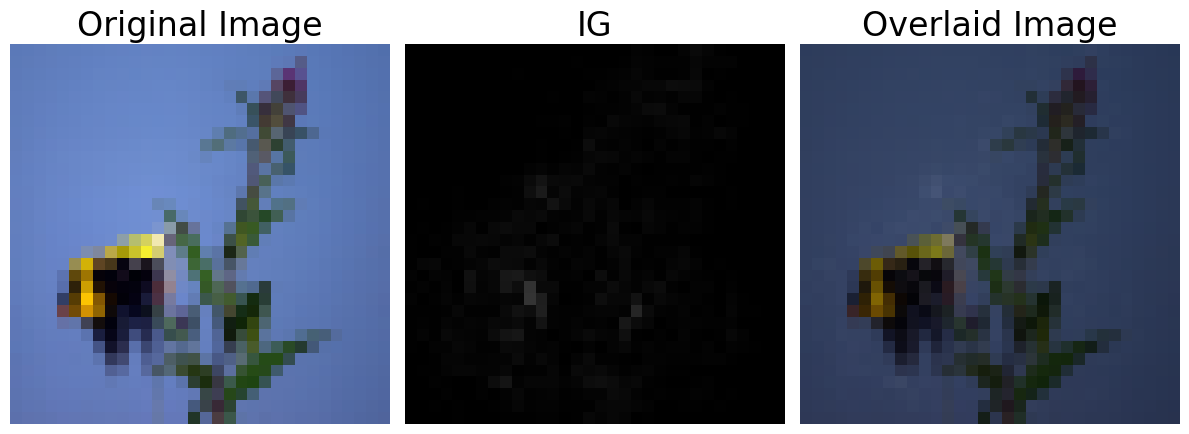

In [73]:
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Original Image", fontsize=24)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(igs_norm[4])
plt.title("IG", fontsize=24)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(overlay_image)
plt.title("Overlaid Image", fontsize=24)
plt.axis('off')

plt.tight_layout()
plt.savefig("ImageNet_igs.pdf")
plt.show()

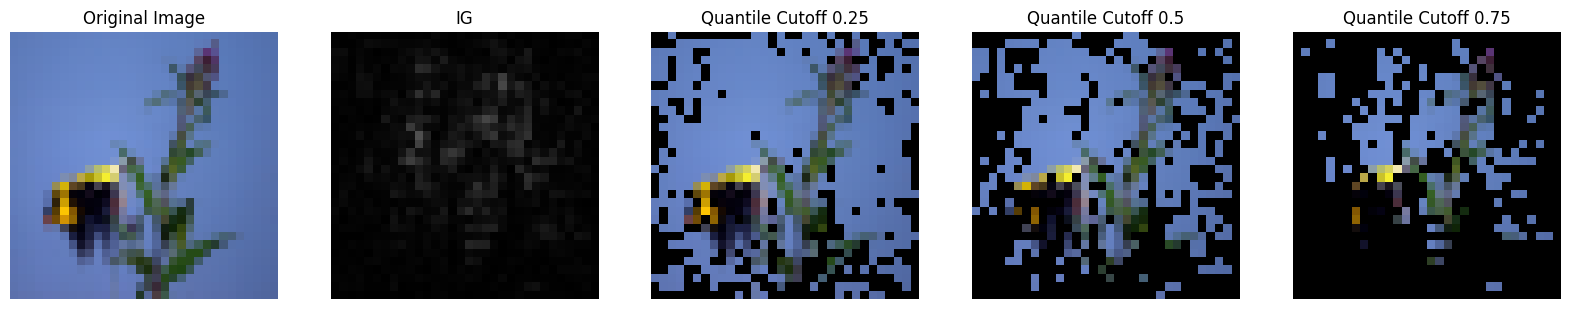

In [77]:
sample = 120

img, label = imagenet_ig[sample]

quantile_values = [np.quantile(igs_norm[sample], q) for q in [0.25, 0.5, 0.75]]
masks_quantile = [(igs_norm[sample] > quantile) for quantile in quantile_values]
masked_images_quantile = [np.where(mask, image, 0) for mask in masks_quantile]

# Plotting with quantile-based cutoffs
fig, ax = plt.subplots(1, 5, figsize=(20, 4))  # 5 subplots

# Display original image
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Display IG
ax[1].imshow(igs_norm[sample], cmap='gray')
ax[1].set_title('IG')
ax[1].axis('off')

# Display masked images for each quantile threshold
for i, (masked_image, quantile) in enumerate(zip(masked_images_quantile, [0.25, 0.5, 0.75]), start=2):
    ax[i].imshow(masked_image, cmap='gray')
    ax[i].set_title(f'Quantile Cutoff {quantile}')
    ax[i].axis('off')

plt.show()

# Train the student models and evaluate

## Data Loading & Preprocess

### Transforms

In [31]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

student_aug = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

### Imagenet Load 

In [32]:
reshaped_data.shape

(4900, 32, 32, 3)

In [33]:
# Convert to PyTorch tensors
student_images_tensor = torch.stack([transform(img) for img in reshaped_data])

In [34]:
student_images_tensor.min()

tensor(0.)

In [35]:
# Optionally, create a dataset and dataloader
student_dataset = torch.utils.data.TensorDataset(student_images_tensor, labels_tensor)
student_dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

In [36]:
img, _ = student_dataset[0]
img.max()

tensor(0.9765)

### hyperparams

In [37]:
# Hyperparameters
NUM_EPOCHS = 100
BATCH_SIZE = 64
LEARN_RATE = 0.001
NUM_WORKERS = 16
ALPHA=0.1
TEMP=3

### Test Data

In [38]:
# load student data
test_data = CIFAR10(
    root="../PyTorch_CIFAR10/data",
    train=False,
    transform=transform,
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=True,
)

### Load Precomputed IG and Logits

In [36]:
IGS = "PyTorch_CIFAR10/Captum_IGs.npy"
# Load the precomputed IGs
igs = np.load(IGS)
print(f"IGs shape: {igs.shape}")

IGs shape: (50000, 32, 32)


In [37]:
precomputed_logits = np.load("PyTorch_CIFAR10/data/cifar10_logits.npy")
print("Shape of teacher_logits:", precomputed_logits.shape)

Shape of teacher_logits: (50000, 10)


# KD_IG (overlay_prob=0.5)

## Training

In [33]:
# Define the full training dataset without augmentation for splitting
train_dataset = CIFAR10WithIG(
    igs=igs,
    root="PyTorch_CIFAR10/data",
    train=True,
    transform=student_aug,
    precomputed_logits=precomputed_logits,
    overlay_prob=0.5,
    return_ig=False,
)

Files already downloaded and verified


In [34]:
# Load the data into batches
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=True,
)

In [39]:
KD_IG_5 = SmallerMobileNet(mobilenet_v2(pretrained=False))
KD_IG_5.to(device);

In [39]:
Trained_KD_IG_5, acc = train_eval_kd(
    student=KD_IG_5,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=NUM_EPOCHS,
    lr=LEARN_RATE,
    TEMP=TEMP,
    ALPHA=ALPHA,
    device=device,
    csv_path="PyTorch_CIFAR10/Histories/Results/KD_IG_0.5.csv",
)

Epoch 1/100: Loss: 1.8565,            Accuracy: 40.52%


Epoch 2/100: Loss: 1.5072,            Accuracy: 58.37%


Epoch 3/100: Loss: 1.3302,            Accuracy: 67.33%


Epoch 4/100: Loss: 1.2245,            Accuracy: 71.86%


Epoch 5/100: Loss: 1.1561,            Accuracy: 75.11%


Epoch 6/100: Loss: 1.1026,            Accuracy: 77.13%


Epoch 7/100: Loss: 1.0673,            Accuracy: 78.70%


Epoch 8/100: Loss: 1.0301,            Accuracy: 80.37%


Epoch 9/100: Loss: 1.0064,            Accuracy: 81.17%


Epoch 10/100: Loss: 0.9826,            Accuracy: 82.30%


Epoch 11/100: Loss: 0.9599,            Accuracy: 83.22%


Epoch 12/100: Loss: 0.9433,            Accuracy: 83.87%


Epoch 13/100: Loss: 0.9242,            Accuracy: 84.69%


Epoch 14/100: Loss: 0.9094,            Accuracy: 85.39%


Epoch 15/100: Loss: 0.8962,            Accuracy: 85.93%


Epoch 16/100: Loss: 0.8846,            Accuracy: 86.41%


Epoch 17/100: Loss: 0.8744,            Accuracy: 86.64%


Epoch 18/100: Loss: 0.8608,            Accuracy: 87.49%


Epoch 19/100: Loss: 0.8507,            Accuracy: 87.77%


Epoch 20/100: Loss: 0.8416,            Accuracy: 88.16%


Epoch 21/100: Loss: 0.8353,            Accuracy: 88.40%


Epoch 22/100: Loss: 0.8239,            Accuracy: 88.84%


Epoch 23/100: Loss: 0.8130,            Accuracy: 89.44%


Epoch 24/100: Loss: 0.8087,            Accuracy: 89.55%


Epoch 25/100: Loss: 0.7986,            Accuracy: 89.96%


Epoch 26/100: Loss: 0.7953,            Accuracy: 90.06%


Epoch 27/100: Loss: 0.7866,            Accuracy: 90.47%


Epoch 28/100: Loss: 0.7802,            Accuracy: 90.70%


Epoch 29/100: Loss: 0.7755,            Accuracy: 91.09%


Epoch 30/100: Loss: 0.7703,            Accuracy: 91.14%


Epoch 31/100: Loss: 0.7640,            Accuracy: 91.32%


Epoch 32/100: Loss: 0.7583,            Accuracy: 91.64%


Epoch 33/100: Loss: 0.7547,            Accuracy: 91.76%


Epoch 34/100: Loss: 0.7487,            Accuracy: 92.11%


Epoch 35/100: Loss: 0.7427,            Accuracy: 92.31%


Epoch 36/100: Loss: 0.7408,            Accuracy: 92.38%


Epoch 37/100: Loss: 0.7340,            Accuracy: 92.70%


Epoch 38/100: Loss: 0.7317,            Accuracy: 92.74%


Epoch 39/100: Loss: 0.7274,            Accuracy: 92.86%


Epoch 40/100: Loss: 0.7248,            Accuracy: 93.09%


Epoch 41/100: Loss: 0.7189,            Accuracy: 93.23%


Epoch 42/100: Loss: 0.7130,            Accuracy: 93.38%


Epoch 43/100: Loss: 0.7121,            Accuracy: 93.55%


Epoch 44/100: Loss: 0.7090,            Accuracy: 93.76%


Epoch 45/100: Loss: 0.7080,            Accuracy: 93.68%


Epoch 46/100: Loss: 0.7014,            Accuracy: 94.11%


Epoch 47/100: Loss: 0.6988,            Accuracy: 93.91%


Epoch 48/100: Loss: 0.6973,            Accuracy: 94.17%


Epoch 49/100: Loss: 0.6930,            Accuracy: 94.32%


Epoch 50/100: Loss: 0.6927,            Accuracy: 94.20%


Epoch 51/100: Loss: 0.6921,            Accuracy: 94.33%


Epoch 52/100: Loss: 0.6839,            Accuracy: 94.71%


Epoch 53/100: Loss: 0.6850,            Accuracy: 94.63%


Epoch 54/100: Loss: 0.6796,            Accuracy: 94.76%


Epoch 55/100: Loss: 0.6803,            Accuracy: 94.79%


Epoch 56/100: Loss: 0.6750,            Accuracy: 95.06%


Epoch 57/100: Loss: 0.6735,            Accuracy: 95.07%


Epoch 58/100: Loss: 0.6728,            Accuracy: 95.08%


Epoch 59/100: Loss: 0.6699,            Accuracy: 95.19%


Epoch 60/100: Loss: 0.6698,            Accuracy: 95.23%


Epoch 61/100: Loss: 0.6647,            Accuracy: 95.45%


Epoch 62/100: Loss: 0.6613,            Accuracy: 95.63%


Epoch 63/100: Loss: 0.6639,            Accuracy: 95.45%


Epoch 64/100: Loss: 0.6574,            Accuracy: 95.66%


Epoch 65/100: Loss: 0.6569,            Accuracy: 95.72%


Epoch 66/100: Loss: 0.6564,            Accuracy: 95.72%


Epoch 67/100: Loss: 0.6548,            Accuracy: 95.82%


Epoch 68/100: Loss: 0.6506,            Accuracy: 95.91%


Epoch 69/100: Loss: 0.6529,            Accuracy: 95.98%


Epoch 70/100: Loss: 0.6525,            Accuracy: 95.85%


Epoch 71/100: Loss: 0.6489,            Accuracy: 96.06%


Epoch 72/100: Loss: 0.6442,            Accuracy: 96.27%


Epoch 73/100: Loss: 0.6453,            Accuracy: 96.15%


Epoch 74/100: Loss: 0.6452,            Accuracy: 96.18%


Epoch 75/100: Loss: 0.6400,            Accuracy: 96.41%


Epoch 76/100: Loss: 0.6433,            Accuracy: 96.19%


Epoch 77/100: Loss: 0.6376,            Accuracy: 96.53%


Epoch 78/100: Loss: 0.6392,            Accuracy: 96.35%


Epoch 79/100: Loss: 0.6389,            Accuracy: 96.38%


Epoch 80/100: Loss: 0.6341,            Accuracy: 96.58%


Epoch 81/100: Loss: 0.6341,            Accuracy: 96.58%


Epoch 82/100: Loss: 0.6353,            Accuracy: 96.42%


Epoch 83/100: Loss: 0.6318,            Accuracy: 96.69%


Epoch 84/100: Loss: 0.6281,            Accuracy: 96.76%


Epoch 85/100: Loss: 0.6299,            Accuracy: 96.70%


Epoch 86/100: Loss: 0.6262,            Accuracy: 96.93%


Epoch 87/100: Loss: 0.6253,            Accuracy: 97.03%


Epoch 88/100: Loss: 0.6239,            Accuracy: 97.12%


Epoch 89/100: Loss: 0.6245,            Accuracy: 96.92%


Epoch 90/100: Loss: 0.6241,            Accuracy: 96.89%


Epoch 91/100: Loss: 0.6218,            Accuracy: 97.07%


Epoch 92/100: Loss: 0.6223,            Accuracy: 97.00%


Epoch 93/100: Loss: 0.6206,            Accuracy: 97.15%


Epoch 94/100: Loss: 0.6215,            Accuracy: 96.96%


Epoch 95/100: Loss: 0.6190,            Accuracy: 97.08%


Epoch 96/100: Loss: 0.6179,            Accuracy: 97.20%


Epoch 97/100: Loss: 0.6158,            Accuracy: 97.29%


Epoch 98/100: Loss: 0.6172,            Accuracy: 97.22%


Epoch 99/100: Loss: 0.6115,            Accuracy: 97.43%


Epoch 100/100: Loss: 0.6151,            Accuracy: 97.30%


In [40]:
print(f"Test Acc = {acc:.2f}%")

Test Acc = 91.32%


## Save model

In [49]:
torch.save(Trained_KD_IG_25.state_dict(), "saved_models/KD_IG_5.pt")

## Load model

In [40]:
KD_IG_5.load_state_dict(torch.load("../saved_models/KD_IG_5.pt", weights_only=True))

<All keys matched successfully>

## Test on ImageNet

In [41]:
test_model(model=KD_IG_5, loader=student_dataloader, device=device)

Accuracy of the model on the Training images: 20.714285714285715


In [42]:
metrics = evaluate_model_performance(model=KD_IG_5, dataloader=student_dataloader, device=device, num_classes=10)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# Print F1-Score report
print("\nF1-Score Report:")
for class_idx, report in metrics["f1_report"].items():
    if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
        print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
print("\nConfusion Matrix:")
print(metrics["confusion_matrix"])

Class-wise Accuracy:
Class 0: 70.67%
Class 1: 3.71%
Class 2: 20.14%
Class 3: 52.40%
Class 4: 0.00%
Class 5: 4.53%
Class 6: 23.33%
Class 7: 0.00%
Class 8: 44.40%
Class 9: 1.00%

F1-Score Report:
Class 0: {'precision': 0.05978567399887197, 'recall': 0.7066666666666667, 'f1-score': 0.11024440977639105, 'support': 150.0}
Class 1: {'precision': 0.48148148148148145, 'recall': 0.037142857142857144, 'f1-score': 0.06896551724137931, 'support': 350.0}
Class 2: {'precision': 0.7978142076502732, 'recall': 0.2013793103448276, 'f1-score': 0.32158590308370044, 'support': 2900.0}
Class 3: {'precision': 0.11748878923766816, 'recall': 0.524, 'f1-score': 0.19194139194139195, 'support': 250.0}
Class 4: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0}
Class 5: {'precision': 0.5151515151515151, 'recall': 0.04533333333333334, 'f1-score': 0.08333333333333333, 'support': 750.0}
Class 6: {'precision': 0.06216696269982238, 'recall': 0.23333333333333334, 'f1-score': 0.09817671809256662, 'support

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


# KD_IG (overlay_prob=0.25)

In [38]:
# Define the full training dataset without augmentation for splitting
train_dataset = CIFAR10WithIG(
    igs=igs,
    root="PyTorch_CIFAR10/data",
    train=True,
    transform=student_aug,
    precomputed_logits=precomputed_logits,
    overlay_prob=0.25,
    return_ig=False,
)

Files already downloaded and verified


In [39]:
# Load the data into batches
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=True,
)

In [43]:
KD_IG_OVERLAY_25 = SmallerMobileNet(mobilenet_v2(pretrained=False))
KD_IG_OVERLAY_25.to(device)

SmallerMobileNet(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affi

In [41]:
Trained_KD_IG_OVERLAY_25, acc_kd_ig_25 = train_eval_kd(
    student=KD_IG_OVERLAY_25,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=NUM_EPOCHS,
    lr=LEARN_RATE,
    TEMP=TEMP,
    ALPHA=ALPHA,
    device=device,
    csv_path="PyTorch_CIFAR10/Histories/Results/KD_IG_0.25.csv",
)

Epoch 1/100: Loss: 1.8039,            Accuracy: 43.47%


Epoch 2/100: Loss: 1.4680,            Accuracy: 60.48%


Epoch 3/100: Loss: 1.2990,            Accuracy: 68.35%


Epoch 4/100: Loss: 1.2023,            Accuracy: 73.00%


Epoch 5/100: Loss: 1.1402,            Accuracy: 75.53%


Epoch 6/100: Loss: 1.0950,            Accuracy: 77.56%


Epoch 7/100: Loss: 1.0532,            Accuracy: 79.31%


Epoch 8/100: Loss: 1.0243,            Accuracy: 80.67%


Epoch 9/100: Loss: 0.9962,            Accuracy: 81.87%


Epoch 10/100: Loss: 0.9684,            Accuracy: 82.87%


Epoch 11/100: Loss: 0.9449,            Accuracy: 84.12%


Epoch 12/100: Loss: 0.9297,            Accuracy: 84.55%


Epoch 13/100: Loss: 0.9103,            Accuracy: 85.35%


Epoch 14/100: Loss: 0.8975,            Accuracy: 85.90%


Epoch 15/100: Loss: 0.8807,            Accuracy: 86.72%


Epoch 16/100: Loss: 0.8702,            Accuracy: 87.11%


Epoch 17/100: Loss: 0.8578,            Accuracy: 87.73%


Epoch 18/100: Loss: 0.8473,            Accuracy: 87.97%


Epoch 19/100: Loss: 0.8345,            Accuracy: 88.69%


Epoch 20/100: Loss: 0.8256,            Accuracy: 88.92%


Epoch 21/100: Loss: 0.8139,            Accuracy: 89.25%


Epoch 22/100: Loss: 0.8091,            Accuracy: 89.68%


Epoch 23/100: Loss: 0.8006,            Accuracy: 89.94%


Epoch 24/100: Loss: 0.7899,            Accuracy: 90.46%


Epoch 25/100: Loss: 0.7879,            Accuracy: 90.46%


Epoch 26/100: Loss: 0.7794,            Accuracy: 90.81%


Epoch 27/100: Loss: 0.7703,            Accuracy: 91.25%


Epoch 28/100: Loss: 0.7691,            Accuracy: 91.20%


Epoch 29/100: Loss: 0.7634,            Accuracy: 91.43%


Epoch 30/100: Loss: 0.7539,            Accuracy: 91.78%


Epoch 31/100: Loss: 0.7514,            Accuracy: 91.92%


Epoch 32/100: Loss: 0.7440,            Accuracy: 92.36%


Epoch 33/100: Loss: 0.7414,            Accuracy: 92.38%


Epoch 34/100: Loss: 0.7328,            Accuracy: 92.61%


Epoch 35/100: Loss: 0.7356,            Accuracy: 92.59%


Epoch 36/100: Loss: 0.7264,            Accuracy: 92.94%


Epoch 37/100: Loss: 0.7232,            Accuracy: 93.01%


Epoch 38/100: Loss: 0.7183,            Accuracy: 93.29%


Epoch 39/100: Loss: 0.7156,            Accuracy: 93.41%


Epoch 40/100: Loss: 0.7123,            Accuracy: 93.51%


Epoch 41/100: Loss: 0.7072,            Accuracy: 93.77%


Epoch 42/100: Loss: 0.7028,            Accuracy: 93.89%


Epoch 43/100: Loss: 0.6986,            Accuracy: 94.09%


Epoch 44/100: Loss: 0.6984,            Accuracy: 94.07%


Epoch 45/100: Loss: 0.6932,            Accuracy: 94.36%


Epoch 46/100: Loss: 0.6917,            Accuracy: 94.41%


Epoch 47/100: Loss: 0.6892,            Accuracy: 94.51%


Epoch 48/100: Loss: 0.6878,            Accuracy: 94.44%


Epoch 49/100: Loss: 0.6822,            Accuracy: 94.87%


Epoch 50/100: Loss: 0.6800,            Accuracy: 94.91%


Epoch 51/100: Loss: 0.6769,            Accuracy: 94.99%


Epoch 52/100: Loss: 0.6738,            Accuracy: 95.09%


Epoch 53/100: Loss: 0.6738,            Accuracy: 95.06%


Epoch 54/100: Loss: 0.6710,            Accuracy: 95.08%


Epoch 55/100: Loss: 0.6677,            Accuracy: 95.28%


Epoch 56/100: Loss: 0.6688,            Accuracy: 95.32%


Epoch 57/100: Loss: 0.6655,            Accuracy: 95.37%


Epoch 58/100: Loss: 0.6624,            Accuracy: 95.59%


Epoch 59/100: Loss: 0.6604,            Accuracy: 95.67%


Epoch 60/100: Loss: 0.6627,            Accuracy: 95.49%


Epoch 61/100: Loss: 0.6579,            Accuracy: 95.69%


Epoch 62/100: Loss: 0.6532,            Accuracy: 95.89%


Epoch 63/100: Loss: 0.6526,            Accuracy: 95.86%


Epoch 64/100: Loss: 0.6489,            Accuracy: 96.10%


Epoch 65/100: Loss: 0.6505,            Accuracy: 95.93%


Epoch 66/100: Loss: 0.6483,            Accuracy: 96.15%


Epoch 67/100: Loss: 0.6468,            Accuracy: 96.14%


Epoch 68/100: Loss: 0.6439,            Accuracy: 96.27%


Epoch 69/100: Loss: 0.6463,            Accuracy: 96.09%


Epoch 70/100: Loss: 0.6417,            Accuracy: 96.41%


Epoch 71/100: Loss: 0.6392,            Accuracy: 96.43%


Epoch 72/100: Loss: 0.6383,            Accuracy: 96.39%


Epoch 73/100: Loss: 0.6366,            Accuracy: 96.53%


Epoch 74/100: Loss: 0.6378,            Accuracy: 96.49%


Epoch 75/100: Loss: 0.6358,            Accuracy: 96.53%


Epoch 76/100: Loss: 0.6369,            Accuracy: 96.45%


Epoch 77/100: Loss: 0.6324,            Accuracy: 96.70%


Epoch 78/100: Loss: 0.6325,            Accuracy: 96.73%


Epoch 79/100: Loss: 0.6332,            Accuracy: 96.69%


Epoch 80/100: Loss: 0.6293,            Accuracy: 96.87%


Epoch 81/100: Loss: 0.6294,            Accuracy: 96.77%


Epoch 82/100: Loss: 0.6281,            Accuracy: 96.86%


Epoch 83/100: Loss: 0.6237,            Accuracy: 97.13%


Epoch 84/100: Loss: 0.6278,            Accuracy: 96.84%


Epoch 85/100: Loss: 0.6258,            Accuracy: 96.95%


Epoch 86/100: Loss: 0.6227,            Accuracy: 97.07%


Epoch 87/100: Loss: 0.6203,            Accuracy: 97.16%


Epoch 88/100: Loss: 0.6223,            Accuracy: 97.10%


Epoch 89/100: Loss: 0.6207,            Accuracy: 97.13%


Epoch 90/100: Loss: 0.6186,            Accuracy: 97.16%


Epoch 91/100: Loss: 0.6155,            Accuracy: 97.39%


Epoch 92/100: Loss: 0.6197,            Accuracy: 97.19%


Epoch 93/100: Loss: 0.6166,            Accuracy: 97.26%


Epoch 94/100: Loss: 0.6183,            Accuracy: 97.20%


Epoch 95/100: Loss: 0.6155,            Accuracy: 97.33%


Epoch 96/100: Loss: 0.6129,            Accuracy: 97.41%


Epoch 97/100: Loss: 0.6170,            Accuracy: 97.25%


Epoch 98/100: Loss: 0.6127,            Accuracy: 97.36%


Epoch 99/100: Loss: 0.6132,            Accuracy: 97.38%


Epoch 100/100: Loss: 0.6095,            Accuracy: 97.63%


In [42]:
print(f"Test Acc = {acc_kd_ig_25:.2f}%")

Test Acc = 91.82%


### Save the model

In [43]:
torch.save(Trained_KD_IG_OVERLAY_25.state_dict(), "saved_models/KD_IG_25.pt")

## Test on ImageNet

In [46]:
KD_IG_OVERLAY_25.load_state_dict(torch.load("../saved_models/KD_IG_25.pt", weights_only=True))

<All keys matched successfully>

In [47]:
test_model(model=KD_IG_OVERLAY_25, loader=student_dataloader, device=device)

Accuracy of the model on the Training images: 19.102040816326532


In [48]:
metrics = evaluate_model_performance(model=KD_IG_OVERLAY_25, dataloader=student_dataloader, device=device, num_classes=10)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# Print F1-Score report
print("\nF1-Score Report:")
for class_idx, report in metrics["f1_report"].items():
    if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
        print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
print("\nConfusion Matrix:")
print(metrics["confusion_matrix"])

Class-wise Accuracy:
Class 0: 64.00%
Class 1: 43.14%
Class 2: 12.55%
Class 3: 58.80%
Class 4: 0.00%
Class 5: 6.93%
Class 6: 23.33%
Class 7: 0.00%
Class 8: 35.20%
Class 9: 3.00%

F1-Score Report:
Class 0: {'precision': 0.06221646143875567, 'recall': 0.64, 'f1-score': 0.11340815121086828, 'support': 150.0}
Class 1: {'precision': 0.2926356589147287, 'recall': 0.43142857142857144, 'f1-score': 0.34872979214780603, 'support': 350.0}
Class 2: {'precision': 0.8708133971291866, 'recall': 0.12551724137931033, 'f1-score': 0.21940928270042195, 'support': 2900.0}
Class 3: {'precision': 0.0967741935483871, 'recall': 0.588, 'f1-score': 0.16619559072922555, 'support': 250.0}
Class 4: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0}
Class 5: {'precision': 0.8253968253968254, 'recall': 0.06933333333333333, 'f1-score': 0.12792127921279212, 'support': 750.0}
Class 6: {'precision': 0.0625, 'recall': 0.23333333333333334, 'f1-score': 0.09859154929577464, 'support': 150.0}
Class 7: {'precisi

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


# IG (overlay_prob=0.5)

In [45]:
# Define the full training dataset without augmentation for splitting
train_dataset = CIFAR10WithIG(
    igs=igs,
    root="PyTorch_CIFAR10/data",
    train=True,
    transform=student_aug,
    precomputed_logits=precomputed_logits,
    overlay_prob=0.5,
    return_ig=False,
)

Files already downloaded and verified


In [46]:
# Load the data into batches
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=True,
)

In [47]:
IG_OVERLAY_5 = SmallerMobileNet(mobilenet_v2(pretrained=False))
IG_OVERLAY_5.to(device)

SmallerMobileNet(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affi

In [48]:
Trained_IG_OVERLAY_5, acc_ig_5 = train_eval_kd(
    student=IG_OVERLAY_5,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=NUM_EPOCHS,
    lr=LEARN_RATE,
    TEMP=1,
    ALPHA=0,
    device=device,
    csv_path="PyTorch_CIFAR10/Histories/Results/IG_0.5.csv",
)

Epoch 1/100: Loss: 1.5774,            Accuracy: 41.96%


Epoch 2/100: Loss: 1.1523,            Accuracy: 58.76%


Epoch 3/100: Loss: 0.9336,            Accuracy: 66.92%


Epoch 4/100: Loss: 0.8095,            Accuracy: 71.68%


Epoch 5/100: Loss: 0.7286,            Accuracy: 74.55%


Epoch 6/100: Loss: 0.6662,            Accuracy: 76.80%


Epoch 7/100: Loss: 0.6165,            Accuracy: 78.59%


Epoch 8/100: Loss: 0.5808,            Accuracy: 79.70%


Epoch 9/100: Loss: 0.5500,            Accuracy: 80.99%


Epoch 10/100: Loss: 0.5163,            Accuracy: 82.22%


Epoch 11/100: Loss: 0.4937,            Accuracy: 82.86%


Epoch 12/100: Loss: 0.4715,            Accuracy: 83.61%


Epoch 13/100: Loss: 0.4498,            Accuracy: 84.42%


Epoch 14/100: Loss: 0.4310,            Accuracy: 85.00%


Epoch 15/100: Loss: 0.4146,            Accuracy: 85.56%


Epoch 16/100: Loss: 0.4043,            Accuracy: 85.90%


Epoch 17/100: Loss: 0.3871,            Accuracy: 86.48%


Epoch 18/100: Loss: 0.3716,            Accuracy: 87.03%


Epoch 19/100: Loss: 0.3594,            Accuracy: 87.57%


Epoch 20/100: Loss: 0.3505,            Accuracy: 87.80%


Epoch 21/100: Loss: 0.3401,            Accuracy: 88.15%


Epoch 22/100: Loss: 0.3347,            Accuracy: 88.32%


Epoch 23/100: Loss: 0.3196,            Accuracy: 88.84%


Epoch 24/100: Loss: 0.3112,            Accuracy: 89.19%


Epoch 25/100: Loss: 0.2999,            Accuracy: 89.56%


Epoch 26/100: Loss: 0.2980,            Accuracy: 89.63%


Epoch 27/100: Loss: 0.2865,            Accuracy: 89.85%


Epoch 28/100: Loss: 0.2847,            Accuracy: 89.97%


Epoch 29/100: Loss: 0.2761,            Accuracy: 90.35%


Epoch 30/100: Loss: 0.2657,            Accuracy: 90.56%


Epoch 31/100: Loss: 0.2584,            Accuracy: 90.94%


Epoch 32/100: Loss: 0.2553,            Accuracy: 90.99%


Epoch 33/100: Loss: 0.2482,            Accuracy: 91.33%


Epoch 34/100: Loss: 0.2411,            Accuracy: 91.53%


Epoch 35/100: Loss: 0.2352,            Accuracy: 91.69%


Epoch 36/100: Loss: 0.2304,            Accuracy: 91.73%


Epoch 37/100: Loss: 0.2300,            Accuracy: 91.89%


Epoch 38/100: Loss: 0.2240,            Accuracy: 92.10%


Epoch 39/100: Loss: 0.2150,            Accuracy: 92.32%


Epoch 40/100: Loss: 0.2122,            Accuracy: 92.54%


Epoch 41/100: Loss: 0.2082,            Accuracy: 92.75%


Epoch 42/100: Loss: 0.2007,            Accuracy: 92.85%


Epoch 43/100: Loss: 0.2008,            Accuracy: 92.78%


Epoch 44/100: Loss: 0.1985,            Accuracy: 92.87%


Epoch 45/100: Loss: 0.1895,            Accuracy: 93.22%


Epoch 46/100: Loss: 0.1899,            Accuracy: 93.35%


Epoch 47/100: Loss: 0.1818,            Accuracy: 93.54%


Epoch 48/100: Loss: 0.1839,            Accuracy: 93.57%


Epoch 49/100: Loss: 0.1760,            Accuracy: 93.74%


Epoch 50/100: Loss: 0.1757,            Accuracy: 93.63%


Epoch 51/100: Loss: 0.1750,            Accuracy: 93.91%


Epoch 52/100: Loss: 0.1644,            Accuracy: 94.23%


Epoch 53/100: Loss: 0.1668,            Accuracy: 94.14%


Epoch 54/100: Loss: 0.1695,            Accuracy: 93.92%


Epoch 55/100: Loss: 0.1598,            Accuracy: 94.36%


Epoch 56/100: Loss: 0.1543,            Accuracy: 94.45%


Epoch 57/100: Loss: 0.1562,            Accuracy: 94.43%


Epoch 58/100: Loss: 0.1507,            Accuracy: 94.66%


Epoch 59/100: Loss: 0.1553,            Accuracy: 94.45%


Epoch 60/100: Loss: 0.1464,            Accuracy: 94.87%


Epoch 61/100: Loss: 0.1437,            Accuracy: 94.92%


Epoch 62/100: Loss: 0.1437,            Accuracy: 94.89%


Epoch 63/100: Loss: 0.1418,            Accuracy: 95.03%


Epoch 64/100: Loss: 0.1396,            Accuracy: 95.06%


Epoch 65/100: Loss: 0.1364,            Accuracy: 95.13%


Epoch 66/100: Loss: 0.1334,            Accuracy: 95.31%


Epoch 67/100: Loss: 0.1304,            Accuracy: 95.39%


Epoch 68/100: Loss: 0.1286,            Accuracy: 95.52%


Epoch 69/100: Loss: 0.1307,            Accuracy: 95.45%


Epoch 70/100: Loss: 0.1266,            Accuracy: 95.51%


Epoch 71/100: Loss: 0.1281,            Accuracy: 95.42%


Epoch 72/100: Loss: 0.1219,            Accuracy: 95.75%


Epoch 73/100: Loss: 0.1220,            Accuracy: 95.68%


Epoch 74/100: Loss: 0.1234,            Accuracy: 95.67%


Epoch 75/100: Loss: 0.1173,            Accuracy: 95.74%


Epoch 76/100: Loss: 0.1144,            Accuracy: 95.90%


Epoch 77/100: Loss: 0.1129,            Accuracy: 96.06%


Epoch 78/100: Loss: 0.1131,            Accuracy: 95.90%


Epoch 79/100: Loss: 0.1134,            Accuracy: 95.89%


Epoch 80/100: Loss: 0.1110,            Accuracy: 96.05%


Epoch 81/100: Loss: 0.1091,            Accuracy: 96.08%


Epoch 82/100: Loss: 0.1098,            Accuracy: 96.12%


Epoch 83/100: Loss: 0.1055,            Accuracy: 96.19%


Epoch 84/100: Loss: 0.1039,            Accuracy: 96.41%


Epoch 85/100: Loss: 0.1025,            Accuracy: 96.37%


Epoch 86/100: Loss: 0.1045,            Accuracy: 96.30%


Epoch 87/100: Loss: 0.1007,            Accuracy: 96.45%


Epoch 88/100: Loss: 0.1008,            Accuracy: 96.42%


Epoch 89/100: Loss: 0.0993,            Accuracy: 96.45%


Epoch 90/100: Loss: 0.0985,            Accuracy: 96.62%


Epoch 91/100: Loss: 0.0983,            Accuracy: 96.55%


Epoch 92/100: Loss: 0.0964,            Accuracy: 96.60%


Epoch 93/100: Loss: 0.0956,            Accuracy: 96.73%


Epoch 94/100: Loss: 0.0953,            Accuracy: 96.62%


Epoch 95/100: Loss: 0.0966,            Accuracy: 96.71%


Epoch 96/100: Loss: 0.0905,            Accuracy: 96.90%


Epoch 97/100: Loss: 0.0890,            Accuracy: 96.81%


Epoch 98/100: Loss: 0.0916,            Accuracy: 96.81%


Epoch 99/100: Loss: 0.0884,            Accuracy: 96.89%


Epoch 100/100: Loss: 0.0876,            Accuracy: 96.92%


In [49]:
print(f"Test Acc = {acc_ig_5:.2f}%")

Test Acc = 90.95%


### Save the model

In [50]:
torch.save(Trained_IG_OVERLAY_5.state_dict(), "saved_models/IG_5.pt")

## Test on ImageNet

In [51]:
test_model(model=Trained_IG_OVERLAY_5, loader=student_dataloader, device=device)

Accuracy of the model on the Training images: 28.8


# IG (overlay_prob=0.25)

In [52]:
# Define the full training dataset without augmentation for splitting
train_dataset = CIFAR10WithIG(
    igs=igs,
    root="PyTorch_CIFAR10/data",
    train=True,
    transform=student_aug,
    precomputed_logits=precomputed_logits,
    overlay_prob=0.25,
    return_ig=False,
)

# Load the data into batches
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=True,
)

Files already downloaded and verified


In [53]:
IG_OVERLAY_25 = SmallerMobileNet(mobilenet_v2(pretrained=False))
IG_OVERLAY_25.to(device)

SmallerMobileNet(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affi

In [54]:
Trained_IG_OVERLAY_25, acc_ig_25 = train_eval_kd(
    student=IG_OVERLAY_25,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=NUM_EPOCHS,
    lr=LEARN_RATE,
    TEMP=1,
    ALPHA=0,
    device=device,
    csv_path="PyTorch_CIFAR10/Histories/Results/IG_0.25.csv",
)

Epoch 1/100: Loss: 1.5374,            Accuracy: 43.16%


Epoch 2/100: Loss: 1.0935,            Accuracy: 60.91%


Epoch 3/100: Loss: 0.8733,            Accuracy: 69.39%


Epoch 4/100: Loss: 0.7533,            Accuracy: 73.74%


Epoch 5/100: Loss: 0.6802,            Accuracy: 76.30%


Epoch 6/100: Loss: 0.6252,            Accuracy: 78.30%


Epoch 7/100: Loss: 0.5782,            Accuracy: 79.74%


Epoch 8/100: Loss: 0.5444,            Accuracy: 81.26%


Epoch 9/100: Loss: 0.5085,            Accuracy: 82.38%


Epoch 10/100: Loss: 0.4787,            Accuracy: 83.27%


Epoch 11/100: Loss: 0.4594,            Accuracy: 84.05%


Epoch 12/100: Loss: 0.4320,            Accuracy: 84.89%


Epoch 13/100: Loss: 0.4173,            Accuracy: 85.61%


Epoch 14/100: Loss: 0.3986,            Accuracy: 86.24%


Epoch 15/100: Loss: 0.3808,            Accuracy: 86.78%


Epoch 16/100: Loss: 0.3634,            Accuracy: 87.39%


Epoch 17/100: Loss: 0.3533,            Accuracy: 87.62%


Epoch 18/100: Loss: 0.3400,            Accuracy: 88.12%


Epoch 19/100: Loss: 0.3293,            Accuracy: 88.51%


Epoch 20/100: Loss: 0.3203,            Accuracy: 88.74%


Epoch 21/100: Loss: 0.3070,            Accuracy: 89.23%


Epoch 22/100: Loss: 0.2976,            Accuracy: 89.49%


Epoch 23/100: Loss: 0.2928,            Accuracy: 89.84%


Epoch 24/100: Loss: 0.2826,            Accuracy: 90.16%


Epoch 25/100: Loss: 0.2771,            Accuracy: 90.24%


Epoch 26/100: Loss: 0.2676,            Accuracy: 90.63%


Epoch 27/100: Loss: 0.2565,            Accuracy: 90.97%


Epoch 28/100: Loss: 0.2504,            Accuracy: 91.11%


Epoch 29/100: Loss: 0.2418,            Accuracy: 91.41%


Epoch 30/100: Loss: 0.2383,            Accuracy: 91.64%


Epoch 31/100: Loss: 0.2283,            Accuracy: 91.88%


Epoch 32/100: Loss: 0.2273,            Accuracy: 92.09%


Epoch 33/100: Loss: 0.2225,            Accuracy: 92.34%


Epoch 34/100: Loss: 0.2184,            Accuracy: 92.31%


Epoch 35/100: Loss: 0.2091,            Accuracy: 92.70%


Epoch 36/100: Loss: 0.2071,            Accuracy: 92.64%


Epoch 37/100: Loss: 0.2025,            Accuracy: 92.86%


Epoch 38/100: Loss: 0.1959,            Accuracy: 93.29%


Epoch 39/100: Loss: 0.1950,            Accuracy: 93.14%


Epoch 40/100: Loss: 0.1928,            Accuracy: 93.24%


Epoch 41/100: Loss: 0.1828,            Accuracy: 93.50%


Epoch 42/100: Loss: 0.1798,            Accuracy: 93.68%


Epoch 43/100: Loss: 0.1771,            Accuracy: 93.88%


Epoch 44/100: Loss: 0.1732,            Accuracy: 93.86%


Epoch 45/100: Loss: 0.1712,            Accuracy: 94.03%


Epoch 46/100: Loss: 0.1668,            Accuracy: 93.98%


Epoch 47/100: Loss: 0.1613,            Accuracy: 94.27%


Epoch 48/100: Loss: 0.1618,            Accuracy: 94.26%


Epoch 49/100: Loss: 0.1559,            Accuracy: 94.44%


Epoch 50/100: Loss: 0.1507,            Accuracy: 94.72%


Epoch 51/100: Loss: 0.1541,            Accuracy: 94.58%


Epoch 52/100: Loss: 0.1495,            Accuracy: 94.65%


Epoch 53/100: Loss: 0.1442,            Accuracy: 94.87%


Epoch 54/100: Loss: 0.1433,            Accuracy: 95.02%


Epoch 55/100: Loss: 0.1405,            Accuracy: 95.03%


Epoch 56/100: Loss: 0.1446,            Accuracy: 94.90%


Epoch 57/100: Loss: 0.1364,            Accuracy: 95.15%


Epoch 58/100: Loss: 0.1335,            Accuracy: 95.17%


Epoch 59/100: Loss: 0.1334,            Accuracy: 95.23%


Epoch 60/100: Loss: 0.1333,            Accuracy: 95.21%


Epoch 61/100: Loss: 0.1273,            Accuracy: 95.54%


Epoch 62/100: Loss: 0.1276,            Accuracy: 95.48%


Epoch 63/100: Loss: 0.1267,            Accuracy: 95.48%


Epoch 64/100: Loss: 0.1256,            Accuracy: 95.47%


Epoch 65/100: Loss: 0.1181,            Accuracy: 95.80%


Epoch 66/100: Loss: 0.1215,            Accuracy: 95.63%


Epoch 67/100: Loss: 0.1164,            Accuracy: 95.83%


Epoch 68/100: Loss: 0.1180,            Accuracy: 95.85%


Epoch 69/100: Loss: 0.1148,            Accuracy: 95.94%


Epoch 70/100: Loss: 0.1133,            Accuracy: 96.04%


Epoch 71/100: Loss: 0.1109,            Accuracy: 96.07%


Epoch 72/100: Loss: 0.1117,            Accuracy: 96.07%


Epoch 73/100: Loss: 0.1052,            Accuracy: 96.30%


Epoch 74/100: Loss: 0.1086,            Accuracy: 96.19%


Epoch 75/100: Loss: 0.1093,            Accuracy: 96.16%


Epoch 76/100: Loss: 0.1056,            Accuracy: 96.24%


Epoch 77/100: Loss: 0.1004,            Accuracy: 96.49%


Epoch 78/100: Loss: 0.1013,            Accuracy: 96.48%


Epoch 79/100: Loss: 0.1026,            Accuracy: 96.34%


Epoch 80/100: Loss: 0.1021,            Accuracy: 96.48%


Epoch 81/100: Loss: 0.0986,            Accuracy: 96.57%


Epoch 82/100: Loss: 0.0999,            Accuracy: 96.44%


Epoch 83/100: Loss: 0.0950,            Accuracy: 96.67%


Epoch 84/100: Loss: 0.0962,            Accuracy: 96.67%


Epoch 85/100: Loss: 0.0965,            Accuracy: 96.63%


Epoch 86/100: Loss: 0.0962,            Accuracy: 96.63%


Epoch 87/100: Loss: 0.0878,            Accuracy: 96.94%


Epoch 88/100: Loss: 0.0900,            Accuracy: 96.79%


Epoch 89/100: Loss: 0.0904,            Accuracy: 96.79%


Epoch 90/100: Loss: 0.0840,            Accuracy: 97.03%


Epoch 91/100: Loss: 0.0877,            Accuracy: 96.91%


Epoch 92/100: Loss: 0.0876,            Accuracy: 96.98%


Epoch 93/100: Loss: 0.0840,            Accuracy: 97.10%


Epoch 94/100: Loss: 0.0861,            Accuracy: 96.95%


Epoch 95/100: Loss: 0.0845,            Accuracy: 97.06%


Epoch 96/100: Loss: 0.0863,            Accuracy: 96.93%


Epoch 97/100: Loss: 0.0776,            Accuracy: 97.30%


Epoch 98/100: Loss: 0.0818,            Accuracy: 97.07%


Epoch 99/100: Loss: 0.0813,            Accuracy: 97.08%


Epoch 100/100: Loss: 0.0803,            Accuracy: 97.23%


In [55]:
print(f"Test Acc = {acc_ig_25:.2f}%")

Test Acc = 91.31%


### Save the model

In [56]:
torch.save(Trained_IG_OVERLAY_25.state_dict(), "saved_models/IG_25.pt")

## Test on ImageNet

In [57]:
test_model(model=Trained_IG_OVERLAY_25, loader=student_dataloader, device=device)

Accuracy of the model on the Training images: 22.6


# KD

In [58]:
train_dataset = CIFAR10_KD(
    root="PyTorch_CIFAR10/data",
    train=True,
    transform=student_aug,
    precomputed_logits=precomputed_logits,
)

# Load the data into batches
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=True,
)

Files already downloaded and verified


In [59]:
KD = SmallerMobileNet(mobilenet_v2(pretrained=False))
KD.to(device)

SmallerMobileNet(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affi

In [60]:
Trained_KD, acc_kd = train_eval_kd(
    student=KD,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=NUM_EPOCHS,
    lr=LEARN_RATE,
    TEMP=3,
    ALPHA=0.1,
    device=device,
    csv_path="PyTorch_CIFAR10/Histories/Results/KD.csv",
)

Epoch 1/100: Loss: 1.7249,            Accuracy: 47.51%


Epoch 2/100: Loss: 1.3800,            Accuracy: 64.62%


Epoch 3/100: Loss: 1.2136,            Accuracy: 72.55%


Epoch 4/100: Loss: 1.1128,            Accuracy: 76.92%


Epoch 5/100: Loss: 1.0489,            Accuracy: 79.74%


Epoch 6/100: Loss: 0.9988,            Accuracy: 81.67%


Epoch 7/100: Loss: 0.9621,            Accuracy: 83.38%


Epoch 8/100: Loss: 0.9331,            Accuracy: 84.58%


Epoch 9/100: Loss: 0.9115,            Accuracy: 85.54%


Epoch 10/100: Loss: 0.8848,            Accuracy: 86.54%


Epoch 11/100: Loss: 0.8692,            Accuracy: 87.23%


Epoch 12/100: Loss: 0.8507,            Accuracy: 87.87%


Epoch 13/100: Loss: 0.8341,            Accuracy: 88.50%


Epoch 14/100: Loss: 0.8187,            Accuracy: 89.26%


Epoch 15/100: Loss: 0.8062,            Accuracy: 89.77%


Epoch 16/100: Loss: 0.7943,            Accuracy: 90.24%


Epoch 17/100: Loss: 0.7843,            Accuracy: 90.78%


Epoch 18/100: Loss: 0.7710,            Accuracy: 91.25%


Epoch 19/100: Loss: 0.7648,            Accuracy: 91.49%


Epoch 20/100: Loss: 0.7536,            Accuracy: 91.89%


Epoch 21/100: Loss: 0.7475,            Accuracy: 92.16%


Epoch 22/100: Loss: 0.7414,            Accuracy: 92.39%


Epoch 23/100: Loss: 0.7330,            Accuracy: 92.69%


Epoch 24/100: Loss: 0.7264,            Accuracy: 92.84%


Epoch 25/100: Loss: 0.7170,            Accuracy: 93.45%


Epoch 26/100: Loss: 0.7147,            Accuracy: 93.43%


Epoch 27/100: Loss: 0.7085,            Accuracy: 93.64%


Epoch 28/100: Loss: 0.7037,            Accuracy: 93.86%


Epoch 29/100: Loss: 0.7002,            Accuracy: 94.01%


Epoch 30/100: Loss: 0.6904,            Accuracy: 94.52%


Epoch 31/100: Loss: 0.6851,            Accuracy: 94.75%


Epoch 32/100: Loss: 0.6846,            Accuracy: 94.61%


Epoch 33/100: Loss: 0.6776,            Accuracy: 94.96%


Epoch 34/100: Loss: 0.6730,            Accuracy: 95.28%


Epoch 35/100: Loss: 0.6714,            Accuracy: 95.22%


Epoch 36/100: Loss: 0.6681,            Accuracy: 95.29%


Epoch 37/100: Loss: 0.6636,            Accuracy: 95.54%


Epoch 38/100: Loss: 0.6593,            Accuracy: 95.76%


Epoch 39/100: Loss: 0.6568,            Accuracy: 95.94%


Epoch 40/100: Loss: 0.6534,            Accuracy: 95.94%


Epoch 41/100: Loss: 0.6498,            Accuracy: 96.03%


Epoch 42/100: Loss: 0.6498,            Accuracy: 96.04%


Epoch 43/100: Loss: 0.6406,            Accuracy: 96.44%


Epoch 44/100: Loss: 0.6406,            Accuracy: 96.43%


Epoch 45/100: Loss: 0.6370,            Accuracy: 96.66%


Epoch 46/100: Loss: 0.6373,            Accuracy: 96.60%


Epoch 47/100: Loss: 0.6317,            Accuracy: 96.80%


Epoch 48/100: Loss: 0.6312,            Accuracy: 96.79%


Epoch 49/100: Loss: 0.6295,            Accuracy: 96.92%


Epoch 50/100: Loss: 0.6285,            Accuracy: 96.96%


Epoch 51/100: Loss: 0.6240,            Accuracy: 96.98%


Epoch 52/100: Loss: 0.6247,            Accuracy: 97.14%


Epoch 53/100: Loss: 0.6222,            Accuracy: 97.10%


Epoch 54/100: Loss: 0.6194,            Accuracy: 97.21%


Epoch 55/100: Loss: 0.6196,            Accuracy: 97.20%


Epoch 56/100: Loss: 0.6177,            Accuracy: 97.24%


Epoch 57/100: Loss: 0.6140,            Accuracy: 97.43%


Epoch 58/100: Loss: 0.6125,            Accuracy: 97.49%


Epoch 59/100: Loss: 0.6114,            Accuracy: 97.60%


Epoch 60/100: Loss: 0.6126,            Accuracy: 97.44%


Epoch 61/100: Loss: 0.6060,            Accuracy: 97.72%


Epoch 62/100: Loss: 0.6092,            Accuracy: 97.61%


Epoch 63/100: Loss: 0.6057,            Accuracy: 97.80%


Epoch 64/100: Loss: 0.6044,            Accuracy: 97.86%


Epoch 65/100: Loss: 0.6034,            Accuracy: 97.90%


Epoch 66/100: Loss: 0.6014,            Accuracy: 97.98%


Epoch 67/100: Loss: 0.6018,            Accuracy: 97.91%


Epoch 68/100: Loss: 0.5995,            Accuracy: 98.03%


Epoch 69/100: Loss: 0.6000,            Accuracy: 97.92%


Epoch 70/100: Loss: 0.5973,            Accuracy: 98.08%


Epoch 71/100: Loss: 0.5962,            Accuracy: 98.09%


Epoch 72/100: Loss: 0.5963,            Accuracy: 98.09%


Epoch 73/100: Loss: 0.5954,            Accuracy: 98.07%


Epoch 74/100: Loss: 0.5938,            Accuracy: 98.13%


Epoch 75/100: Loss: 0.5907,            Accuracy: 98.34%


Epoch 76/100: Loss: 0.5903,            Accuracy: 98.38%


Epoch 77/100: Loss: 0.5923,            Accuracy: 98.22%


Epoch 78/100: Loss: 0.5911,            Accuracy: 98.26%


Epoch 79/100: Loss: 0.5877,            Accuracy: 98.42%


Epoch 80/100: Loss: 0.5878,            Accuracy: 98.39%


Epoch 81/100: Loss: 0.5899,            Accuracy: 98.25%


Epoch 82/100: Loss: 0.5869,            Accuracy: 98.46%


Epoch 83/100: Loss: 0.5851,            Accuracy: 98.51%


Epoch 84/100: Loss: 0.5828,            Accuracy: 98.62%


Epoch 85/100: Loss: 0.5861,            Accuracy: 98.43%


Epoch 86/100: Loss: 0.5837,            Accuracy: 98.56%


Epoch 87/100: Loss: 0.5827,            Accuracy: 98.54%


Epoch 88/100: Loss: 0.5809,            Accuracy: 98.63%


Epoch 89/100: Loss: 0.5818,            Accuracy: 98.58%


Epoch 90/100: Loss: 0.5808,            Accuracy: 98.61%


Epoch 91/100: Loss: 0.5799,            Accuracy: 98.67%


Epoch 92/100: Loss: 0.5804,            Accuracy: 98.64%


Epoch 93/100: Loss: 0.5778,            Accuracy: 98.77%


Epoch 94/100: Loss: 0.5768,            Accuracy: 98.75%


Epoch 95/100: Loss: 0.5773,            Accuracy: 98.74%


Epoch 96/100: Loss: 0.5786,            Accuracy: 98.68%


Epoch 97/100: Loss: 0.5761,            Accuracy: 98.79%


Epoch 98/100: Loss: 0.5766,            Accuracy: 98.76%


Epoch 99/100: Loss: 0.5762,            Accuracy: 98.76%


Epoch 100/100: Loss: 0.5747,            Accuracy: 98.81%


In [61]:
print(f"Test Acc = {acc_kd:.2f}%")

Test Acc = 91.69%


### Save the model

In [62]:
torch.save(Trained_KD.state_dict(), "saved_models/KD.pt")

## Test on ImageNet

In [63]:
test_model(model=Trained_KD, loader=student_dataloader, device=device)

Accuracy of the model on the Training images: 30.0


# Student (baseline)

In [64]:
train_dataset = CIFAR10_KD(
    root="PyTorch_CIFAR10/data",
    train=True,
    transform=student_aug,
    precomputed_logits=precomputed_logits,
)

# Load the data into batches
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=True,
)

Files already downloaded and verified


In [65]:
student = SmallerMobileNet(mobilenet_v2(pretrained=False))
student.to(device)

SmallerMobileNet(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affi

In [66]:
Trained_student, acc_student = train_eval_kd(
    student=student,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=NUM_EPOCHS,
    lr=LEARN_RATE,
    TEMP=1,
    ALPHA=0,
    device=device,
    csv_path="PyTorch_CIFAR10/Histories/Results/Student.csv",
)

Epoch 1/100: Loss: 1.4212,            Accuracy: 48.48%


Epoch 2/100: Loss: 0.9781,            Accuracy: 65.22%


Epoch 3/100: Loss: 0.7850,            Accuracy: 72.26%


Epoch 4/100: Loss: 0.6652,            Accuracy: 76.81%


Epoch 5/100: Loss: 0.5915,            Accuracy: 79.44%


Epoch 6/100: Loss: 0.5330,            Accuracy: 81.54%


Epoch 7/100: Loss: 0.4948,            Accuracy: 82.98%


Epoch 8/100: Loss: 0.4581,            Accuracy: 84.13%


Epoch 9/100: Loss: 0.4294,            Accuracy: 85.14%


Epoch 10/100: Loss: 0.4039,            Accuracy: 85.90%


Epoch 11/100: Loss: 0.3796,            Accuracy: 87.03%


Epoch 12/100: Loss: 0.3644,            Accuracy: 87.47%


Epoch 13/100: Loss: 0.3389,            Accuracy: 88.25%


Epoch 14/100: Loss: 0.3216,            Accuracy: 88.89%


Epoch 15/100: Loss: 0.3053,            Accuracy: 89.32%


Epoch 16/100: Loss: 0.2972,            Accuracy: 89.62%


Epoch 17/100: Loss: 0.2814,            Accuracy: 90.33%


Epoch 18/100: Loss: 0.2708,            Accuracy: 90.56%


Epoch 19/100: Loss: 0.2559,            Accuracy: 90.92%


Epoch 20/100: Loss: 0.2464,            Accuracy: 91.34%


Epoch 21/100: Loss: 0.2386,            Accuracy: 91.72%


Epoch 22/100: Loss: 0.2310,            Accuracy: 91.92%


Epoch 23/100: Loss: 0.2206,            Accuracy: 92.26%


Epoch 24/100: Loss: 0.2138,            Accuracy: 92.40%


Epoch 25/100: Loss: 0.2025,            Accuracy: 92.85%


Epoch 26/100: Loss: 0.1979,            Accuracy: 93.00%


Epoch 27/100: Loss: 0.1916,            Accuracy: 93.26%


Epoch 28/100: Loss: 0.1830,            Accuracy: 93.50%


Epoch 29/100: Loss: 0.1782,            Accuracy: 93.78%


Epoch 30/100: Loss: 0.1719,            Accuracy: 93.90%


Epoch 31/100: Loss: 0.1660,            Accuracy: 94.19%


Epoch 32/100: Loss: 0.1600,            Accuracy: 94.22%


Epoch 33/100: Loss: 0.1520,            Accuracy: 94.59%


Epoch 34/100: Loss: 0.1533,            Accuracy: 94.63%


Epoch 35/100: Loss: 0.1448,            Accuracy: 94.79%


Epoch 36/100: Loss: 0.1444,            Accuracy: 94.83%


Epoch 37/100: Loss: 0.1396,            Accuracy: 94.91%


Epoch 38/100: Loss: 0.1337,            Accuracy: 95.29%


Epoch 39/100: Loss: 0.1324,            Accuracy: 95.39%


Epoch 40/100: Loss: 0.1294,            Accuracy: 95.34%


Epoch 41/100: Loss: 0.1202,            Accuracy: 95.75%


Epoch 42/100: Loss: 0.1230,            Accuracy: 95.66%


Epoch 43/100: Loss: 0.1189,            Accuracy: 95.81%


Epoch 44/100: Loss: 0.1130,            Accuracy: 95.95%


Epoch 45/100: Loss: 0.1104,            Accuracy: 96.11%


Epoch 46/100: Loss: 0.1128,            Accuracy: 95.95%


Epoch 47/100: Loss: 0.1005,            Accuracy: 96.41%


Epoch 48/100: Loss: 0.1084,            Accuracy: 96.11%


Epoch 49/100: Loss: 0.1055,            Accuracy: 96.18%


Epoch 50/100: Loss: 0.0944,            Accuracy: 96.79%


Epoch 51/100: Loss: 0.1001,            Accuracy: 96.44%


Epoch 52/100: Loss: 0.0966,            Accuracy: 96.68%


Epoch 53/100: Loss: 0.0958,            Accuracy: 96.65%


Epoch 54/100: Loss: 0.0906,            Accuracy: 96.73%


Epoch 55/100: Loss: 0.0887,            Accuracy: 96.90%


Epoch 56/100: Loss: 0.0904,            Accuracy: 96.81%


Epoch 57/100: Loss: 0.0877,            Accuracy: 96.91%


Epoch 58/100: Loss: 0.0823,            Accuracy: 97.01%


Epoch 59/100: Loss: 0.0846,            Accuracy: 96.91%


Epoch 60/100: Loss: 0.0801,            Accuracy: 97.21%


Epoch 61/100: Loss: 0.0811,            Accuracy: 97.11%


Epoch 62/100: Loss: 0.0727,            Accuracy: 97.41%


Epoch 63/100: Loss: 0.0790,            Accuracy: 97.19%


Epoch 64/100: Loss: 0.0779,            Accuracy: 97.27%


Epoch 65/100: Loss: 0.0739,            Accuracy: 97.33%


Epoch 66/100: Loss: 0.0756,            Accuracy: 97.35%


Epoch 67/100: Loss: 0.0704,            Accuracy: 97.56%


Epoch 68/100: Loss: 0.0660,            Accuracy: 97.61%


Epoch 69/100: Loss: 0.0701,            Accuracy: 97.58%


Epoch 70/100: Loss: 0.0699,            Accuracy: 97.54%


Epoch 71/100: Loss: 0.0675,            Accuracy: 97.54%


Epoch 72/100: Loss: 0.0657,            Accuracy: 97.67%


Epoch 73/100: Loss: 0.0658,            Accuracy: 97.63%


Epoch 74/100: Loss: 0.0666,            Accuracy: 97.64%


Epoch 75/100: Loss: 0.0626,            Accuracy: 97.77%


Epoch 76/100: Loss: 0.0668,            Accuracy: 97.60%


Epoch 77/100: Loss: 0.0599,            Accuracy: 97.86%


Epoch 78/100: Loss: 0.0632,            Accuracy: 97.75%


Epoch 79/100: Loss: 0.0620,            Accuracy: 97.77%


Epoch 80/100: Loss: 0.0582,            Accuracy: 97.96%


Epoch 81/100: Loss: 0.0579,            Accuracy: 97.93%


Epoch 82/100: Loss: 0.0560,            Accuracy: 98.00%


Epoch 83/100: Loss: 0.0599,            Accuracy: 97.92%


Epoch 84/100: Loss: 0.0550,            Accuracy: 98.06%


Epoch 85/100: Loss: 0.0537,            Accuracy: 98.10%


Epoch 86/100: Loss: 0.0578,            Accuracy: 97.94%


Epoch 87/100: Loss: 0.0547,            Accuracy: 98.07%


Epoch 88/100: Loss: 0.0529,            Accuracy: 98.07%


Epoch 89/100: Loss: 0.0559,            Accuracy: 98.06%


Epoch 90/100: Loss: 0.0527,            Accuracy: 98.18%


Epoch 91/100: Loss: 0.0492,            Accuracy: 98.30%


Epoch 92/100: Loss: 0.0515,            Accuracy: 98.20%


Epoch 93/100: Loss: 0.0508,            Accuracy: 98.27%


Epoch 94/100: Loss: 0.0532,            Accuracy: 98.11%


Epoch 95/100: Loss: 0.0478,            Accuracy: 98.35%


Epoch 96/100: Loss: 0.0540,            Accuracy: 98.11%


Epoch 97/100: Loss: 0.0496,            Accuracy: 98.24%


Epoch 98/100: Loss: 0.0486,            Accuracy: 98.27%


Epoch 99/100: Loss: 0.0474,            Accuracy: 98.34%


Epoch 100/100: Loss: 0.0482,            Accuracy: 98.33%


In [67]:
print(f"Test Acc = {acc_student:.2f}%")

Test Acc = 91.35%


### Save the model

In [68]:
torch.save(Trained_student.state_dict(), "saved_models/Student.pt")

## Test on Imagenet

In [69]:
test_model(model=Trained_student, loader=student_dataloader, device=device)

Accuracy of the model on the Training images: 19.4


# Evaluate all models on ImageNet

## Teacher

In [55]:
Teacher = mobilenet_v2(pretrained=True)
Teacher.to(device)

acc = test_model(model=Teacher, loader=dataloader, device=device)

metrics = evaluate_model_performance(model=Teacher, dataloader=dataloader, device=device, num_classes=10)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# # Print F1-Score report
# print("\nF1-Score Report:")
# for class_idx, report in metrics["f1_report"].items():
#     if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
#         print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
# print("\nConfusion Matrix:")
# print(metrics["confusion_matrix"])

Accuracy of the model on the Training images: 68.81632653061224
Class-wise Accuracy:
Class 0: 84.00%
Class 1: 60.29%
Class 2: 73.31%
Class 3: 81.20%
Class 4: 0.00%
Class 5: 46.27%
Class 6: 66.00%
Class 7: 0.00%
Class 8: 77.60%
Class 9: 66.00%

Balanced Accuracy: 0.6933
Cohen's Kappa: 0.5541


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [56]:
KD_IG_5 = SmallerMobileNet(mobilenet_v2(pretrained=False))
KD_IG_5.to(device)

KD_IG_5.load_state_dict(torch.load("../saved_models/KD_IG_5.pt", weights_only=True))

acc = test_model(model=KD_IG_5, loader=student_dataloader, device=device)

metrics = evaluate_model_performance(model=KD_IG_5, dataloader=student_dataloader, device=device, num_classes=10)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# # Print F1-Score report
# print("\nF1-Score Report:")
# for class_idx, report in metrics["f1_report"].items():
#     if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
#         print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
# print("\nConfusion Matrix:")
# print(metrics["confusion_matrix"])

Accuracy of the model on the Training images: 20.714285714285715
Class-wise Accuracy:
Class 0: 70.67%
Class 1: 3.71%
Class 2: 20.14%
Class 3: 52.40%
Class 4: 0.00%
Class 5: 4.53%
Class 6: 23.33%
Class 7: 0.00%
Class 8: 44.40%
Class 9: 1.00%

Balanced Accuracy: 0.2752
Cohen's Kappa: 0.0959


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [57]:
KD_IG_25 = SmallerMobileNet(mobilenet_v2(pretrained=False))
KD_IG_25.to(device)

KD_IG_25.load_state_dict(torch.load("../saved_models/KD_IG_25.pt", weights_only=True))

acc = test_model(model=KD_IG_25, loader=student_dataloader, device=device)

metrics = evaluate_model_performance(model=KD_IG_25, dataloader=student_dataloader, device=device, num_classes=10)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# # Print F1-Score report
# print("\nF1-Score Report:")
# for class_idx, report in metrics["f1_report"].items():
#     if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
#         print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
# print("\nConfusion Matrix:")
# print(metrics["confusion_matrix"])

Accuracy of the model on the Training images: 19.102040816326532
Class-wise Accuracy:
Class 0: 64.00%
Class 1: 43.14%
Class 2: 12.55%
Class 3: 58.80%
Class 4: 0.00%
Class 5: 6.93%
Class 6: 23.33%
Class 7: 0.00%
Class 8: 35.20%
Class 9: 3.00%

Balanced Accuracy: 0.3087
Cohen's Kappa: 0.1096


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [58]:
IG_5 = SmallerMobileNet(mobilenet_v2(pretrained=False))
IG_5.to(device)
IG_5.load_state_dict(torch.load("../saved_models/IG_5.pt", weights_only=True))

acc = test_model(model=IG_5, loader=student_dataloader, device=device)

metrics = evaluate_model_performance(model=IG_5, dataloader=student_dataloader, device=device, num_classes=10)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# # Print F1-Score report
# print("\nF1-Score Report:")
# for class_idx, report in metrics["f1_report"].items():
#     if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
#         print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
# print("\nConfusion Matrix:")
# print(metrics["confusion_matrix"])

Accuracy of the model on the Training images: 17.20408163265306
Class-wise Accuracy:
Class 0: 78.00%
Class 1: 4.57%
Class 2: 11.45%
Class 3: 63.20%
Class 4: 0.00%
Class 5: 3.73%
Class 6: 74.67%
Class 7: 0.00%
Class 8: 24.40%
Class 9: 19.00%

Balanced Accuracy: 0.3488
Cohen's Kappa: 0.1008


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [59]:
IG_25 = SmallerMobileNet(mobilenet_v2(pretrained=False))
IG_25.to(device)

IG_25.load_state_dict(torch.load("../saved_models/IG_25.pt", weights_only=True))

acc = test_model(model=IG_25, loader=student_dataloader, device=device)

metrics = evaluate_model_performance(model=IG_25, dataloader=student_dataloader, device=device, num_classes=10)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# # Print F1-Score report
# print("\nF1-Score Report:")
# for class_idx, report in metrics["f1_report"].items():
#     if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
#         print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
# print("\nConfusion Matrix:")
# print(metrics["confusion_matrix"])

Accuracy of the model on the Training images: 32.63265306122449
Class-wise Accuracy:
Class 0: 72.00%
Class 1: 1.71%
Class 2: 43.00%
Class 3: 64.40%
Class 4: 0.00%
Class 5: 2.13%
Class 6: 3.33%
Class 7: 0.00%
Class 8: 22.40%
Class 9: 0.00%

Balanced Accuracy: 0.2612
Cohen's Kappa: 0.1143


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [60]:
KD = SmallerMobileNet(mobilenet_v2(pretrained=False))
KD.to(device)

KD.load_state_dict(torch.load("../saved_models/KD.pt", weights_only=True))

acc = test_model(model=KD, loader=student_dataloader, device=device)

metrics = evaluate_model_performance(model=KD, dataloader=student_dataloader, device=device, num_classes=10)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# # Print F1-Score report
# print("\nF1-Score Report:")
# for class_idx, report in metrics["f1_report"].items():
#     if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
#         print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
# print("\nConfusion Matrix:")
# print(metrics["confusion_matrix"])

Accuracy of the model on the Training images: 30.081632653061224
Class-wise Accuracy:
Class 0: 73.33%
Class 1: 48.00%
Class 2: 32.38%
Class 3: 24.40%
Class 4: 0.00%
Class 5: 10.40%
Class 6: 22.00%
Class 7: 0.00%
Class 8: 31.60%
Class 9: 6.00%

Balanced Accuracy: 0.3101
Cohen's Kappa: 0.1481


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [61]:
Student = SmallerMobileNet(mobilenet_v2(pretrained=False))
Student.to(device)

Student.load_state_dict(torch.load("../saved_models/Student.pt", weights_only=True))

acc = test_model(model=Student, loader=student_dataloader, device=device)

metrics = evaluate_model_performance(model=Student, dataloader=student_dataloader, device=device, num_classes=10)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# # Print F1-Score report
# print("\nF1-Score Report:")
# for class_idx, report in metrics["f1_report"].items():
#     if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
#         print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
# print("\nConfusion Matrix:")
# print(metrics["confusion_matrix"])

Accuracy of the model on the Training images: 40.265306122448976
Class-wise Accuracy:
Class 0: 83.33%
Class 1: 2.57%
Class 2: 60.31%
Class 3: 22.40%
Class 4: 0.00%
Class 5: 0.93%
Class 6: 6.00%
Class 7: 0.00%
Class 8: 7.20%
Class 9: 0.00%

Balanced Accuracy: 0.2284
Cohen's Kappa: 0.0980


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
